<div align="center">
    
# Jeanette's Workbook

</div>
    
    
<hr style="border:2px solid blue"> </hr>

This workbook contains all my work for the Zillow project involving clustering methodologies. I will do my entire pipeline process here and then coordinate with Joann Balraj on how we will combine our workbooks into a final draft, which we will use to create our video presentation. 


In [1]:
# Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Group-Created Zillow Functions
import wrangle

# Block Warning Boxes
import warnings
warnings.filterwarnings("ignore")


<hr style="border:2px solid blue"> </hr>


# Explore

Unlike our previous zillow project, the target variable will be `logerror`. Since we do not know the Zestimate of the home, nor the price it truely sold for, we only have the logerror as a reference. The goal is to build an adjustment model that will work to improve the Zillow Zestimate model. Much like adjusting the sights on a rifle when it is making an error, our model should adjust the Zestimate to be more accurate. 

In [2]:
# Checking to make sure wrangle.py is working
df = wrangle.get_zillow_data()
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595,2017-01-01,-117869207.0,33634931.0
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619,2017-01-01,-119281531.0,34449266.0
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383,2017-01-01,-117823170.0,33886168.0
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410,2017-01-01,-118240722.0,34245180.0
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011,2017-01-01,-118179824.0,34145202.0


In [3]:
# Time to explore! First I'll split the data
# Using the functions from our compiled wrangle file 
train, validate, test = wrangle.wrangle_zillow()
train, validate, test = wrangle.Min_Max_Scaler(train, validate, test)

In [4]:
train.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude,years_old
36317,3,2.0,0.322392,1959,97104,6111,0.046060,0.034616,2017-07-03,-119189214.0,34170911.0,58
26167,3,2.0,0.328839,1953,96201,6037,0.049221,0.168734,2017-05-23,-118087067.0,33931811.0,64
635,4,2.5,0.596131,1986,97097,6111,0.607301,0.046620,2017-01-05,-118870664.0,34268267.0,31
49331,4,3.0,0.588218,1964,97118,6111,0.321354,-0.001710,2017-09-01,-118736787.0,34254775.0,53
10086,4,2.0,0.351700,1954,96370,6037,0.414059,-0.044853,2017-03-07,-118503960.0,34273188.0,63


In [5]:
# Taking a look at correlations with the target variable
train.corr()['logerror'].sort_values()

tax_value     -0.023246
latitude      -0.020991
years_old     -0.015080
regionidzip    0.001499
fips           0.002151
year_built     0.015080
longitude      0.023194
bathrooms      0.023222
squarefeet     0.028349
bedrooms       0.032285
logerror       1.000000
Name: logerror, dtype: float64

The correlations are not very strong, however it looks like my top 3 features in order are 
1. bedrooms
2. squarefeet
3. bathrooms


Considering that correlations are more for continuous variables, I can really only accept squarefeet from this list at the moment. You could almost consider bathrooms and bedrooms as categorical values.

In [7]:
# What is the mean log error of zestimates?
train.logerror.mean()

0.016410461659818368

In [8]:
# There are negative logerrors in the data. What would mean be if we found the absolute value for all logs?
abs_logs = abs(train.logerror)
abs_logs.mean()

0.06758646405523197

In [9]:
train.logerror.mean()

0.016410461659818368

From the actual competition page:
https://www.kaggle.com/c/zillow-prize-1/discussion/33899

#### Why did Zillow pick the log error instead of an absolute error metric such as RMSE?

>Home sale prices have a right skewed distribution and are also strongly heteroscedastic, so we need to use a relative error metric instead of an absolute metric to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems. While we report Zestimate errors in terms of percentages on Zillow.com because we believe that to be a more intuitive metric for consumers, we do not advocate using percentage error to evaluate models in Zillow Prize, as it may lead to biased models The log error is free of this bias problem and when using the natural logarithm, errors close to 1 approximate percentage errors quite closely. 



Takeaway: Logerror is much larger when looking at the absolute value of errors. On average the true zestimate log error is 0.068. As a percentage, this is approximately -2.69%  
  
ln(0.06758646405523197) = -2.6943475518524465

this a multiple

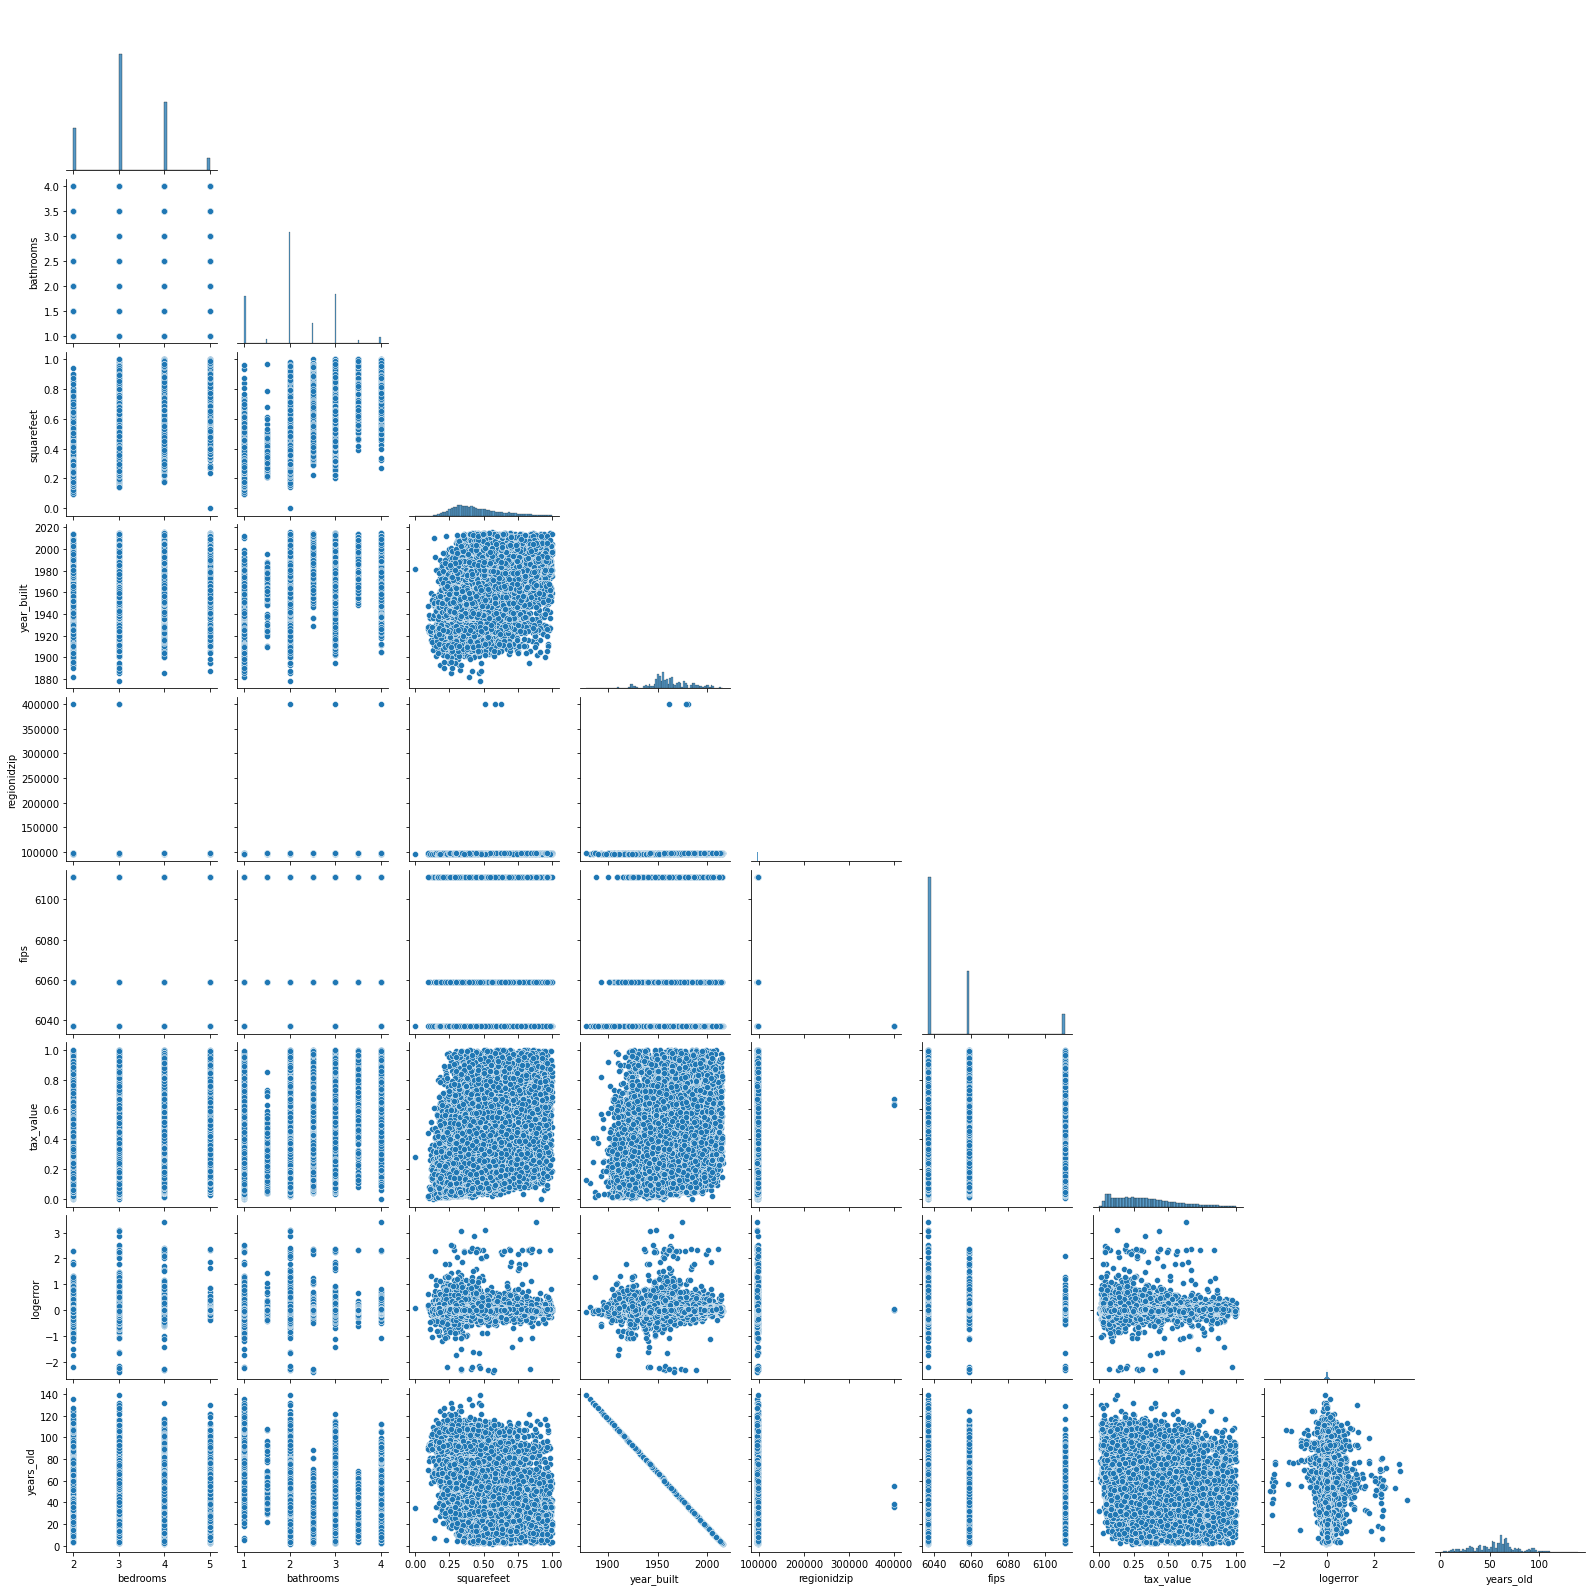

In [11]:
# I'm gonna take a peek at pairplots and see if there's any useful info there
sns.pairplot(train, corner=True);

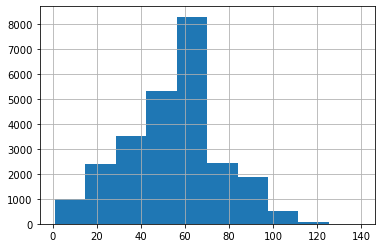

In [10]:
# What is the distribution of my home age?
# It seems that most homes are 60 years of age or younger
train.years_old.hist();

In [11]:
# define function, arguments are dataframe and two lists of columns.
def plot_categorical_and_continuous_vars(df, continuous, categorical):
    '''
    Takes in a dataframe, a list of continuous variables, and a list of categorical 
    variables of the dataframe as arguments. Creates three different plots of each
    categorical pair.
    '''
    # loop through each column in the first list
    for con in continuous:
        # loop through each column in the second list, creating a loop for each categorical pair
        for cat in categorical:
            # each loop returns three subplots in a figure. Plots a swarmplot, stripplot, and boxplot.
            plt.figure(figsize = (20,10))
            plt.subplot(1,3,1)
            sns.swarmplot(x=df[cat], y=df[con], data=df)
            plt.subplot(1,3,2)
            sns.stripplot(x=df[cat], y=df[con], data=df)
            plt.subplot(1,3,3)
            sns.boxplot(x=df[cat], y=df[con], data=df)

In [12]:
continuous = ['tax_value','squarefeet', 'logerror']
categorical= ['bedrooms','bathrooms','years_old','regionidzip']
train.sample(10_000)

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude,years_old
15851,3,2.0,0.318875,1970,96974,6059,0.126419,-0.049619,2017-04-05,-117720536.0,33604097.0,47
50815,2,1.0,0.186987,1950,96186,6059,0.259796,-0.017967,2017-09-08,-117928732.0,33927435.0,67
11377,4,2.0,0.445780,1971,96384,6111,0.475012,0.011204,2017-03-14,-118838709.0,34152308.0,46
28675,4,2.0,0.341149,1962,96489,6037,0.368876,-0.008156,2017-06-01,-117958451.0,34004823.0,55
19659,3,2.0,0.338804,1925,96090,6037,0.277827,0.067825,2017-04-25,-118241525.0,33898042.0,92
...,...,...,...,...,...,...,...,...,...,...,...,...
36452,3,2.0,0.388628,1926,95982,6037,0.028015,-0.169431,2017-07-03,-118252356.0,33976421.0,91
45979,3,2.0,0.321805,1965,96185,6059,0.348693,0.011966,2017-08-18,-118022734.0,33819109.0,52
51355,3,1.0,0.281653,1946,96282,6037,0.186752,-0.000786,2017-09-12,-118303700.0,34261212.0,71
42810,4,2.0,0.504982,1974,97089,6111,0.264381,0.034053,2017-08-02,-119061508.0,34231173.0,43


In [13]:
# Don't run this until finished
#plot_categorical_and_continuous_vars(train.sample(10_000),continuous,categorical )

### Let's do some statistical questions.  
#### 1. Are homes with more bedrooms worth more?

In [22]:
# Setting my confidence level to 95%
alpha = 0.05

In [ ]:
# I'm going to create some array's for this question
tax_value_2Bd = train[train.bedrooms == 2].tax_value
tax_value_5Bd = train[train.bedrooms == 5].tax_value

# Check to see if my variances are equal; (they are not)
# tax_value_2Bd.var() , tax_value_5Bd.var()

# Define my hypothesis before testing:
# H0: There is no difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.
# Ha: There is a difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.

# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(tax_value_2Bd, tax_value_5Bd, equal_var=False)

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

It didn't seem like there was much difference between home value bedrooms in the charts above, but my Two-Tailed T-Test proved otherwise. It seems more bedrooms does mean more value, which seems intuitive, but it's always good to check and see if your data agrees with you.

#### 2. Are younger homes higher in tax_value than old homes?

In [ ]:
# Defining the arrays i want for my t-test
older_homes = train[train.years_old >= train.years_old.mean()].tax_value
younger_homes = train[train.years_old < train.years_old.mean()].tax_value

In [ ]:
# Define my hypothesis before testing:
# H0: Homes older than the average cost more or the same as homes younger than the average
# Ha: Homes older than the average cost less than homes younger than the average

# use stats.ttest to calculate t and p
t, p = stats.ttest_ind(older_homes, younger_homes, equal_var=False)

if p/2 < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

As we expected, the data shows that new homes have higher tax_value than older homes.

#### 3. Are homes with more bathrooms worth more?

In [ ]:
train.bathrooms.value_counts()

In [ ]:
# I'm going to create some array's for this question
tax_value_1Bth = train[train.bathrooms == 1].tax_value
tax_value_4Bth = train[train.bathrooms == 4].tax_value

# Check to see if my variances are equal; (they are not)
# tax_value_2Bd.var() , tax_value_5Bd.var()

# Define my hypothesis before testing:
# H0: There is no difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.
# Ha: There is a difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.

# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(tax_value_2Bd, tax_value_5Bd, equal_var=False)

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

1. Why do some properties have a much higher value than others when they are located so close to each other?
2. Are houses with a high bedroom count but a low bathroom count, less valueable?
3. Are houses of a certain year built more valuable than others?
4. Are there certain countys that are harder to predict taxvaluedollarcnt for?

#### 4. Is the magnitude of log errors higher with older houses?

In [23]:
# I'm going to create some array's for this question
logerror_older = train[train.years_old > train.years_old.mean()].logerror
logerror_younger = train[train.years_old <= train.years_old.mean()].logerror

# Check to see if my variances are equal; (they are not)
# logerror_older.var() , logerror_younger.var()

# Define my hypothesis before testing:
# H0: There is no difference in logerror between homes above the average age vs homes below the average age.
# Ha: There is a difference in logerror between homes above the average age vs homes below the average age.

# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(logerror_older, logerror_younger, equal_var=False)

if p/2 < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


In [30]:
# The log error of old houses is <= the log error of all houses
# The log error of old homes is > the log error of all houses

# calculate t and p statistic
older_homes = train[train.years_old > train.years_old.mean()].logerror
overall_logerror = train.logerror.mean()

t, p = stats.ttest_1samp(older_homes, overall_logerror)

print("t:", t)
if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

t: -1.478308136160542
We fail to reject the null hypothesis


In [29]:
# The log error of old houses is <= the log error of all houses
# The log error of old homes is > the log error of all houses

# calculate t and p statistic
older_homes = abs(train[train.years_old > train.years_old.mean()].logerror)
overall_logerror = abs_logs.mean()

t, p = stats.ttest_1samp(older_homes, overall_logerror)

print("t:", t)
if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

t: 8.86816282458391
We reject the null hypothesis


In [16]:
train.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude,years_old
36317,3,2.0,1252.0,1959,97104,6111,52725.0,0.034616,2017-07-03,-119189214.0,34170911.0,58
26167,3,2.0,1274.0,1953,96201,6037,56275.0,0.168734,2017-05-23,-118087067.0,33931811.0,64
635,4,2.5,2186.0,1986,97097,6111,683000.0,0.046620,2017-01-05,-118870664.0,34268267.0,31
49331,4,3.0,2159.0,1964,97118,6111,361881.0,-0.001710,2017-09-01,-118736787.0,34254775.0,53
10086,4,2.0,1352.0,1954,96370,6037,465989.0,-0.044853,2017-03-07,-118503960.0,34273188.0,63


I wanna see what my most valuable features are according to these feature selection models. To get started, I'll need to split my data and use the train dataset.

In [17]:
# Wrangling my data
# Then assigning my features to X, and target variable to y, for train dataframe
train, validate, test = wrangle.wrangle_zillow()
X_train = train.drop(columns=['logerror', 'transactiondate'])
y_train = train.tax_value


# Select Kbest 

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression

# Parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=2)

# Find the top 2 X's correlated with y
f_selector.fit(X_train, y_train)

# Boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# Get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

print("KBest Top Two Features:", f_feature)

KBest Top Two Features: ['squarefeet', 'tax_value']


# Recursive Feature Elimination

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

print("Recursive Feature Elimination Top Two Features:",rfe_feature)

Recursive Feature Elimination Top Two Features: ['bedrooms', 'tax_value']


In [20]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
0,bedrooms,1
6,tax_value,1
1,bathrooms,2
5,fips,3
2,squarefeet,4
9,years_old,5
3,year_built,6
4,regionidzip,7
7,longitude,8
8,latitude,9


Alright, so two different models put bathrooms at the top of the list (Kbest comes in reverse order). With this, I will assume my top three features to be Bedrooms, Squarefeet, and Squarefeet. I'll explore these further with some statistical tests. 

In [ ]:
col_list = ['bedrooms', 'bathrooms', 'total_living_area']
for col in col_list:
    sns.lmplot(x=col, y="tax_value", data=train, line_kws={'color': 'red'})
    plt.show()

In [21]:
train.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude,years_old
36317,3,2.0,1252.0,1959,97104,6111,52725.0,0.034616,2017-07-03,-119189214.0,34170911.0,58
26167,3,2.0,1274.0,1953,96201,6037,56275.0,0.168734,2017-05-23,-118087067.0,33931811.0,64
635,4,2.5,2186.0,1986,97097,6111,683000.0,0.046620,2017-01-05,-118870664.0,34268267.0,31
49331,4,3.0,2159.0,1964,97118,6111,361881.0,-0.001710,2017-09-01,-118736787.0,34254775.0,53
10086,4,2.0,1352.0,1954,96370,6037,465989.0,-0.044853,2017-03-07,-118503960.0,34273188.0,63


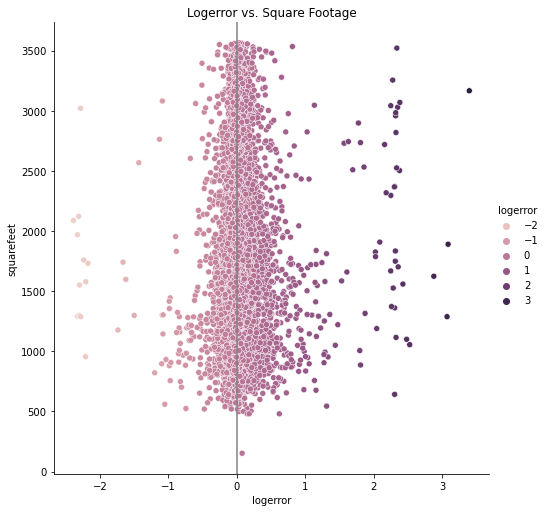

In [38]:
# logerror vs squarefeet
sns.relplot(data=train, x="logerror", y="squarefeet", hue='logerror', height=7, aspect=1).set(title="Logerror vs. Square Footage");
plt.axvline(0, color='grey')



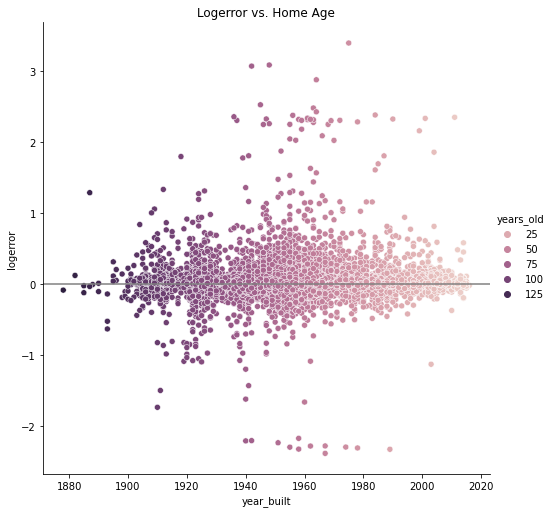

In [37]:
# logerror vs squarefeet
sns.relplot(data=train, x="year_built", y="logerror", hue='years_old', height=7, aspect=1).set(title="Logerror vs. Home Age");
plt.axhline(0, color='grey');



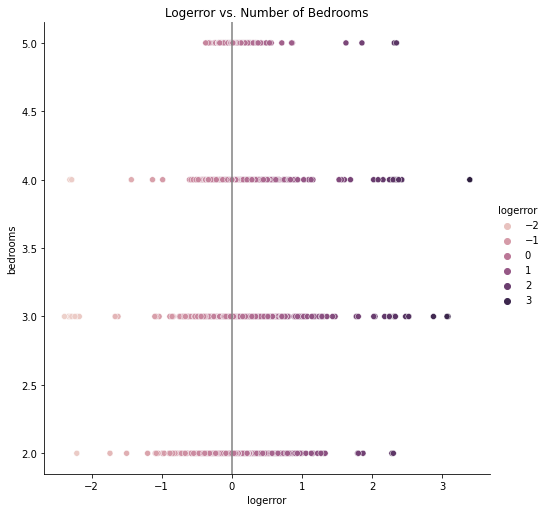

In [34]:
# logerror vs squarefeet
sns.relplot(data=train, x="logerror", y="bedrooms", hue='logerror', height=7, aspect=1).set(title="Logerror vs. Number of Bedrooms");
plt.axvline(0, color='grey')


<span style="color: red">

  
# Explore (.ipynb) - Ask clear question, [discover], provide a clear answer
At least 4 of the questions asked and answered of the data are shared in the final report notebook. You should call out questions of the data using natural language that speaks to the business stakeholders in markdown cells, ideally a header prior to the visualization or statistical test, that you then explore. This does not take the place of stating your null hypothesis/alternative hypothesis when doing a statistical test. But those hypotheses are generally for you. By writing questions that you intend to answer with visualizations and statistical tests in natural language, like "Are office supplies leading to differences in profit in Texas?", you are able to guide both yourself and your reader through the highlights of your analysis. You ask a question, create a visual, run a statistical test (if appropriate), and wrap it nicely with a markdown cell that contains a clear answer in layman's terms. You do all that before moving to the next question.

# Explore (.ipynb) - Exploring though visualizations
At least 5 visualizations are included in your final report. The ones included answer a question (remember, NO is an answer) and the one(s) to provide necessary context (such as the distribution of the target variable). All statistical tests included in the final report should be supported with an visualization of the interaction of the variables being tested. Charts in the final report should have titles and labels that are descriptive and useful for the end user/audience/consumer of the report. All visualizations in the final report are mentioned or discussed if a verbal presentation is given.

# Explore (.ipynb) - Statistical tests
At least 2 statistical tests are included in your final report. The correct tests are run, given the data type and distribution, and the correct conclusions are drawn. - correlation: 2 continuous variables, normally distributed, testing for LINEAR correlation only (H_0: Not linearly dependent) - independent t-test: 1 continuous, somewhat normally distributed variable, one boolean variable, equal variance, independent (H_0: population mean of each group is equal) - chi-square test: 2 discrete variables. (H_0: the 2 variables are independent of each other). (other tests may be used)
    
# Explore (.ipynb) - Summary
Following your exploration section, you summarize your analysis (in a markdown cell using natural language): what you found and how you will use it moving forward. This includes key takeaways from all the questions answered in explore, a list of which features will be used in modeling and why, and which features will not move forward and why. You may only call out a few of these features in the presentation, but having that there for reference is important in a report. A group of features may have the same reason why, and those can be mentioned together.

</span>